In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Dataset

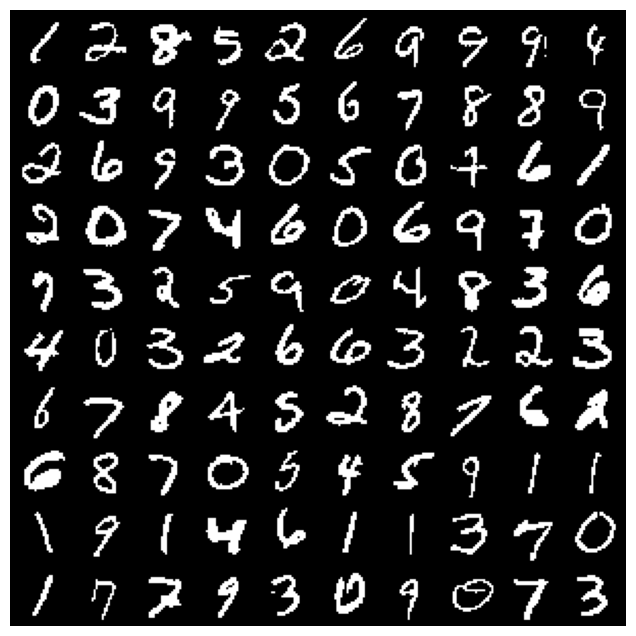

In [2]:
from datasets.binarized_mnist import build_dataloaders
train_loader, test_loader = build_dataloaders(batch_size=100)

# Visualize samples
images, labels = next(iter(train_loader))

# Make a grid of images
grid = utils.make_grid(images, nrow=10, padding=2)

# Plot the grid
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis('off')
plt.show()

In [3]:
from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import subs_parametrization
from models.denoising_models.mlp import MLP
from models.denoising_models.unet_with_attention import UNetWithAttention

batch_size = 64
epochs = 100
vocab_size = 2
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (1, 28, 28)
num_timesteps = 1000
lr = 1e-4

model = MaskedDiffusion(
    denoising_model=UNetWithAttention(
        num_categories=num_categories,
        embedding_dim=64,
        ch_mult=(2, 4, 8),
        num_res_blocks=2,
        attention_resolutions=(1, 2),
        encode_time=False,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="cosine",
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.01)

In [4]:
# model.load_state_dict(torch.load('../model_weights/mdm_binarized_mnist_256.pth'))

Epoch 1/100, Loss (train): 75.2668, Loss (test): 65.3106, LR: 0.00009998


Epoch 2/100, Loss (train): 64.7016, Loss (test): 62.4383, LR: 0.00009990


Epoch 3/100, Loss (train): 62.2860, Loss (test): 61.1786, LR: 0.00009978


Epoch 4/100, Loss (train): 62.2577, Loss (test): 60.3347, LR: 0.00009961


Epoch 5/100, Loss (train): 60.4944, Loss (test): 59.9199, LR: 0.00009939


Epoch 6/100, Loss (train): 59.7372, Loss (test): 59.2501, LR: 0.00009912


Epoch 7/100, Loss (train): 59.3793, Loss (test): 58.7188, LR: 0.00009881


Epoch 8/100, Loss (train): 59.1882, Loss (test): 58.0533, LR: 0.00009844


Epoch 9/100, Loss (train): 58.6201, Loss (test): 57.9368, LR: 0.00009803


Epoch 10/100, Loss (train): 58.3441, Loss (test): 58.2021, LR: 0.00009758


Epoch 11/100, Loss (train): 57.9809, Loss (test): 57.5108, LR: 0.00009707


Epoch 12/100, Loss (train): 57.4953, Loss (test): 57.2930, LR: 0.00009652


Epoch 13/100, Loss (train): 57.8018, Loss (test): 56.6463, LR: 0.00009593


Epoch 14/100, Loss (train): 57.3474, Loss (test): 57.6321, LR: 0.00009529


Epoch 15/100, Loss (train): 57.1691, Loss (test): 57.0904, LR: 0.00009460


Epoch 16/100, Loss (train): 56.9844, Loss (test): 57.0422, LR: 0.00009388


Epoch 17/100, Loss (train): 56.6383, Loss (test): 56.5068, LR: 0.00009311


Epoch 18/100, Loss (train): 56.6484, Loss (test): 56.3893, LR: 0.00009229


Epoch 19/100, Loss (train): 56.3031, Loss (test): 56.3488, LR: 0.00009144


Epoch 20/100, Loss (train): 56.7538, Loss (test): 57.0629, LR: 0.00009055


Epoch 21/100, Loss (train): 56.5304, Loss (test): 56.0773, LR: 0.00008961


Epoch 22/100, Loss (train): 56.0297, Loss (test): 56.0739, LR: 0.00008864


Epoch 23/100, Loss (train): 56.1081, Loss (test): 56.0947, LR: 0.00008763


Epoch 24/100, Loss (train): 55.8776, Loss (test): 55.5200, LR: 0.00008658


Epoch 25/100, Loss (train): 55.9604, Loss (test): 55.8892, LR: 0.00008550


Epoch 26/100, Loss (train): 55.7039, Loss (test): 55.8367, LR: 0.00008439


Epoch 27/100, Loss (train): 55.8730, Loss (test): 56.4953, LR: 0.00008323


Epoch 28/100, Loss (train): 55.8030, Loss (test): 56.1291, LR: 0.00008205


Epoch 29/100, Loss (train): 55.6495, Loss (test): 55.6097, LR: 0.00008084


Epoch 30/100, Loss (train): 55.4819, Loss (test): 55.7497, LR: 0.00007960


Epoch 31/100, Loss (train): 55.5370, Loss (test): 55.5847, LR: 0.00007832


Epoch 32/100, Loss (train): 55.3780, Loss (test): 55.2073, LR: 0.00007702


Epoch 33/100, Loss (train): 55.1660, Loss (test): 55.2496, LR: 0.00007570


Epoch 34/100, Loss (train): 55.5053, Loss (test): 55.5598, LR: 0.00007435


Epoch 35/100, Loss (train): 54.9050, Loss (test): 54.8214, LR: 0.00007297


Epoch 36/100, Loss (train): 55.3565, Loss (test): 55.1354, LR: 0.00007158


Epoch 37/100, Loss (train): 54.8450, Loss (test): 55.6554, LR: 0.00007016


Epoch 38/100, Loss (train): 54.8911, Loss (test): 54.7675, LR: 0.00006872


Epoch 39/100, Loss (train): 54.8750, Loss (test): 55.6204, LR: 0.00006727


Epoch 40/100, Loss (train): 54.9031, Loss (test): 54.7368, LR: 0.00006580


Epoch 41/100, Loss (train): 54.9090, Loss (test): 55.3213, LR: 0.00006431


Epoch 42/100, Loss (train): 54.9098, Loss (test): 55.0852, LR: 0.00006281


Epoch 43/100, Loss (train): 54.8223, Loss (test): 55.0368, LR: 0.00006130


Epoch 44/100, Loss (train): 54.4549, Loss (test): 54.6704, LR: 0.00005978


Epoch 45/100, Loss (train): 54.4135, Loss (test): 54.2617, LR: 0.00005824


Epoch 46/100, Loss (train): 54.5649, Loss (test): 54.4052, LR: 0.00005670


Epoch 47/100, Loss (train): 54.4187, Loss (test): 54.8152, LR: 0.00005516


Epoch 48/100, Loss (train): 54.3745, Loss (test): 54.7742, LR: 0.00005361


Epoch 49/100, Loss (train): 54.4126, Loss (test): 54.4827, LR: 0.00005205


Epoch 50/100, Loss (train): 54.1187, Loss (test): 54.8050, LR: 0.00005050


Epoch 51/100, Loss (train): 54.2723, Loss (test): 54.4326, LR: 0.00004895


Epoch 52/100, Loss (train): 53.9290, Loss (test): 54.8023, LR: 0.00004739


Epoch 53/100, Loss (train): 54.2499, Loss (test): 55.0193, LR: 0.00004584


Epoch 54/100, Loss (train): 53.8304, Loss (test): 54.4591, LR: 0.00004430


Epoch 55/100, Loss (train): 53.7726, Loss (test): 54.3320, LR: 0.00004276


Epoch 56/100, Loss (train): 53.9128, Loss (test): 54.7567, LR: 0.00004122


Epoch 57/100, Loss (train): 53.8311, Loss (test): 54.1810, LR: 0.00003970


Epoch 58/100, Loss (train): 53.9188, Loss (test): 54.7167, LR: 0.00003819


Epoch 59/100, Loss (train): 54.1609, Loss (test): 54.2126, LR: 0.00003669


Epoch 60/100, Loss (train): 53.7893, Loss (test): 54.5474, LR: 0.00003520


Epoch 61/100, Loss (train): 53.7332, Loss (test): 53.9159, LR: 0.00003373


Epoch 62/100, Loss (train): 53.7317, Loss (test): 55.0644, LR: 0.00003228


Epoch 63/100, Loss (train): 53.2091, Loss (test): 54.8126, LR: 0.00003084


Epoch 64/100, Loss (train): 53.3123, Loss (test): 53.7854, LR: 0.00002942


Epoch 65/100, Loss (train): 53.4869, Loss (test): 54.6408, LR: 0.00002803


Epoch 66/100, Loss (train): 53.4421, Loss (test): 54.6324, LR: 0.00002665


Epoch 67/100, Loss (train): 53.5785, Loss (test): 53.9693, LR: 0.00002530


Epoch 68/100, Loss (train): 53.3563, Loss (test): 54.2794, LR: 0.00002398


Epoch 69/100, Loss (train): 53.1510, Loss (test): 54.0421, LR: 0.00002268


Epoch 70/100, Loss (train): 53.1904, Loss (test): 54.2858, LR: 0.00002140


Epoch 71/100, Loss (train): 53.1515, Loss (test): 53.9875, LR: 0.00002016


Epoch 72/100, Loss (train): 53.1409, Loss (test): 53.9410, LR: 0.00001895


Epoch 73/100, Loss (train): 52.8937, Loss (test): 53.7236, LR: 0.00001777


Epoch 74/100, Loss (train): 53.0738, Loss (test): 53.8801, LR: 0.00001661


Epoch 75/100, Loss (train): 53.0976, Loss (test): 53.4509, LR: 0.00001550


Epoch 76/100, Loss (train): 52.8440, Loss (test): 53.4895, LR: 0.00001442


Epoch 77/100, Loss (train): 52.8039, Loss (test): 53.8229, LR: 0.00001337


Epoch 78/100, Loss (train): 52.8018, Loss (test): 54.4719, LR: 0.00001236


Epoch 79/100, Loss (train): 52.6965, Loss (test): 53.9438, LR: 0.00001139


Epoch 80/100, Loss (train): 52.9108, Loss (test): 54.1409, LR: 0.00001045


Epoch 81/100, Loss (train): 52.9113, Loss (test): 53.9921, LR: 0.00000956


Epoch 82/100, Loss (train): 52.6356, Loss (test): 53.7939, LR: 0.00000871


Epoch 83/100, Loss (train): 52.5399, Loss (test): 53.9143, LR: 0.00000789


Epoch 84/100, Loss (train): 52.6382, Loss (test): 53.7409, LR: 0.00000712


Epoch 85/100, Loss (train): 52.5105, Loss (test): 53.9388, LR: 0.00000640


Epoch 86/100, Loss (train): 52.6308, Loss (test): 53.6185, LR: 0.00000571


Epoch 87/100, Loss (train): 52.5117, Loss (test): 53.7060, LR: 0.00000507


Epoch 88/100, Loss (train): 56.5213, Loss (test): 53.7305, LR: 0.00000448


Epoch 89/100, Loss (train): 52.7801, Loss (test): 53.8922, LR: 0.00000393


Epoch 90/100, Loss (train): 52.7088, Loss (test): 53.3819, LR: 0.00000342


Epoch 91/100, Loss (train): 52.6400, Loss (test): 53.6002, LR: 0.00000297


Epoch 92/100, Loss (train): 52.5333, Loss (test): 53.7947, LR: 0.00000256


Epoch 93/100, Loss (train): 52.6815, Loss (test): 53.3516, LR: 0.00000219


Epoch 94/100, Loss (train): 52.6499, Loss (test): 53.7695, LR: 0.00000188


Epoch 95/100, Loss (train): 52.3570, Loss (test): 53.5380, LR: 0.00000161


Epoch 96/100, Loss (train): 52.5965, Loss (test): 53.6306, LR: 0.00000139


Epoch 97/100, Loss (train): 52.6283, Loss (test): 53.3439, LR: 0.00000122


Epoch 98/100, Loss (train): 52.4938, Loss (test): 53.4516, LR: 0.00000110


Epoch 99/100, Loss (train): 52.4630, Loss (test): 54.1214, LR: 0.00000102


Epoch 100/100, Loss (train): 52.5010, Loss (test): 53.4468, LR: 0.00000100


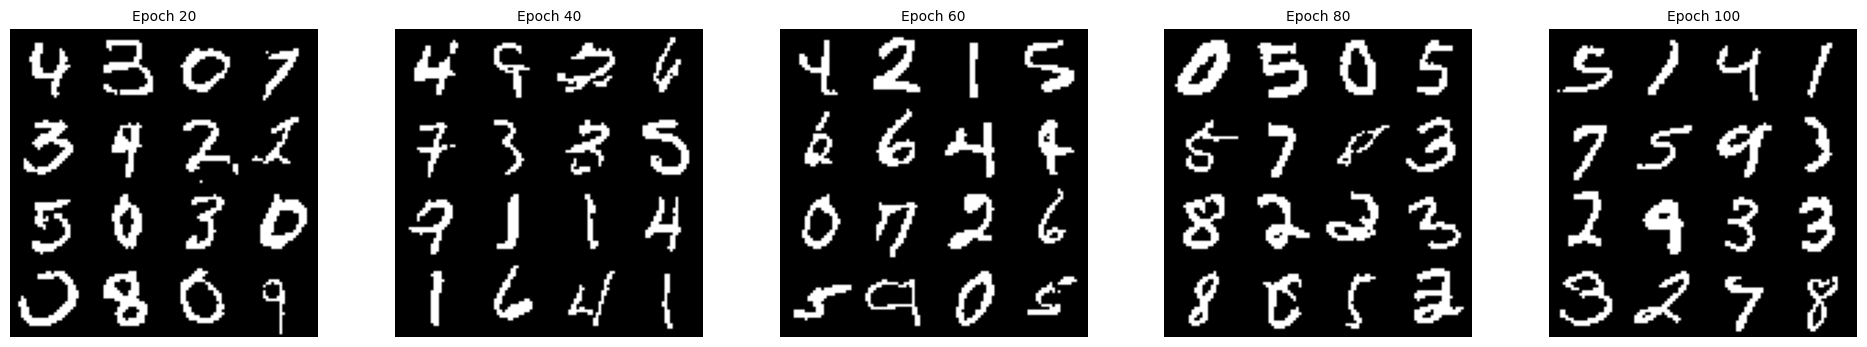

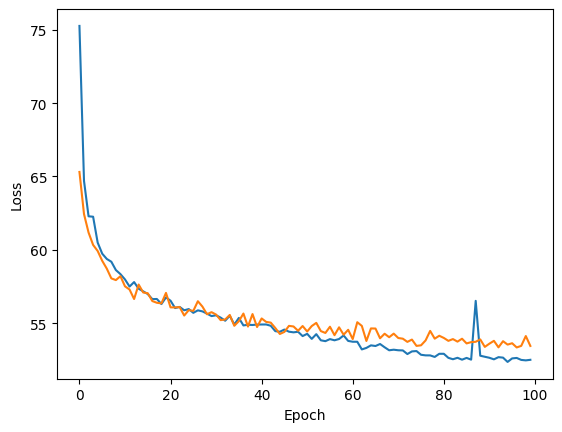

In [5]:
train_loader, test_loader = build_dataloaders(batch_size=batch_size)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(24, 4))
fig_idx = 0

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, labels in train_loader:
        x = x.long().to(device)
        optimizer.zero_grad()
        loss = model(x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
        
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for x, labels in test_loader:
            x = x.long().to(device)
            loss = model(x)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss (train): {train_loss:.4f}, Loss (test): {test_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.8f}")
        
    if (epoch + 1) % (epochs // 5) == 0:
        with torch.no_grad():
            samples = model.sample(num_samples=16, device=device).float().cpu()
        grid = utils.make_grid(samples, nrow=4, padding=0)
        ax[fig_idx].imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
        ax[fig_idx].set_title(f"Epoch {epoch + 1}", fontsize=10)
        ax[fig_idx].axis('off')
        fig_idx += 1
        
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

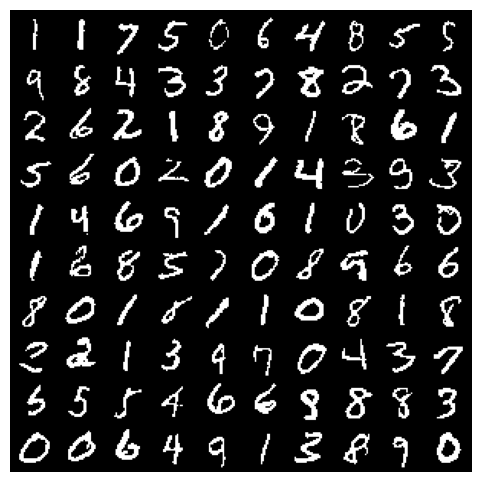

In [6]:
# Visualize samples
model.eval()
with torch.no_grad():
    samples = model.sample(num_samples=100, device=device).float().cpu()
grid = utils.make_grid(samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

In [7]:
# store model weights
torch.save(model.state_dict(), '../model_weights/mdm_binarized_mnist_256.pth')